In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/content/dataset.csv')
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [3]:
# Overview
df.info()
df.describe()
df['target'].value_counts(normalize=True)  # class balance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


,proportion
target,
1,0.528571
0,0.471429


In [5]:
# Check for missing values
df.isnull().sum()



,0
age,0
sex,0
chest pain type,0
resting bp s,0
cholesterol,0
fasting blood sugar,0
resting ecg,0
max heart rate,0
exercise angina,0
oldpeak,0


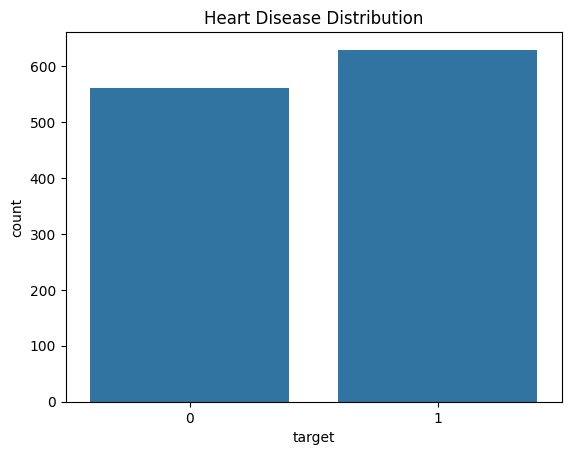

In [6]:
# Visualize class distribution
sns.countplot(x='target', data=df)
plt.title("Heart Disease Distribution")
plt.show()

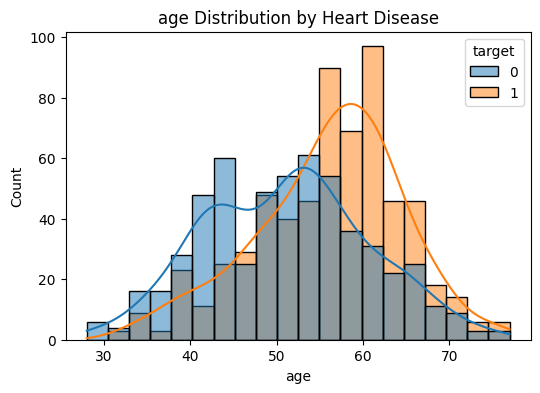

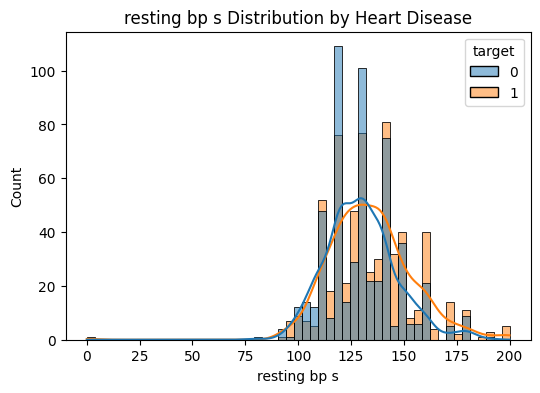

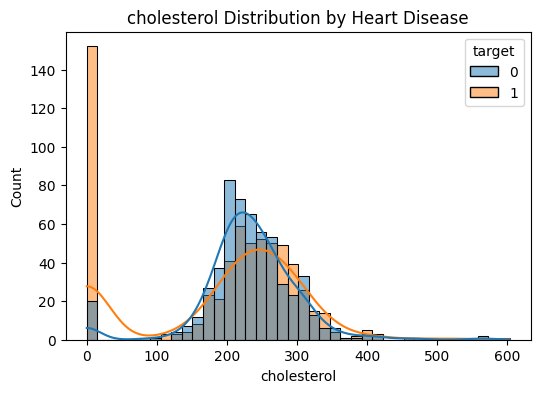

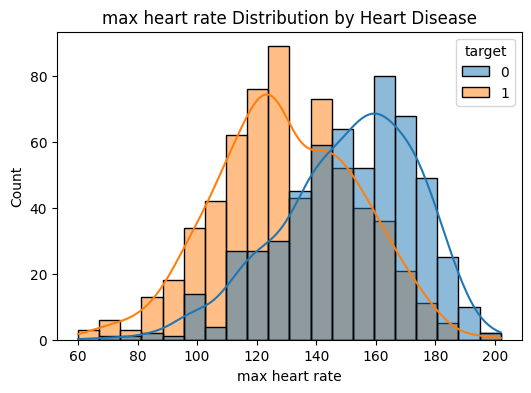

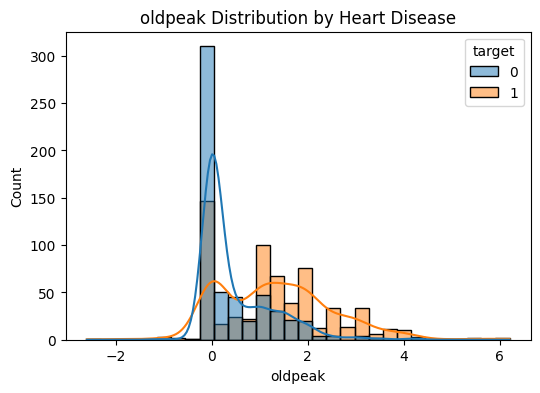

In [7]:
# Numerical features vs target
num_cols = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, hue='target', kde=True)
    plt.title(f'{col} Distribution by Heart Disease')
    plt.show()

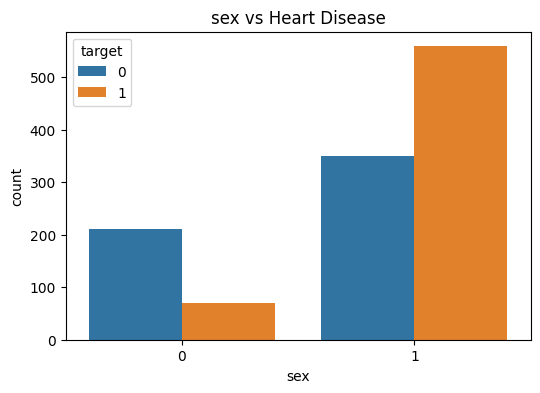

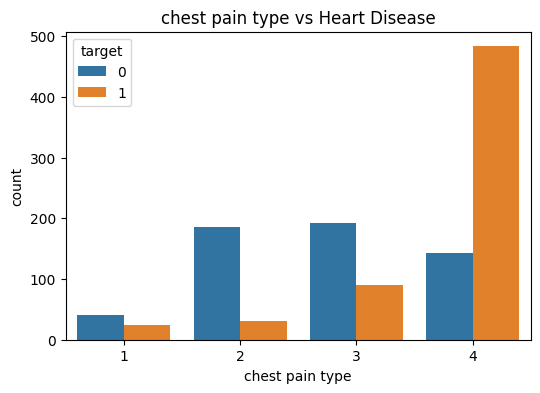

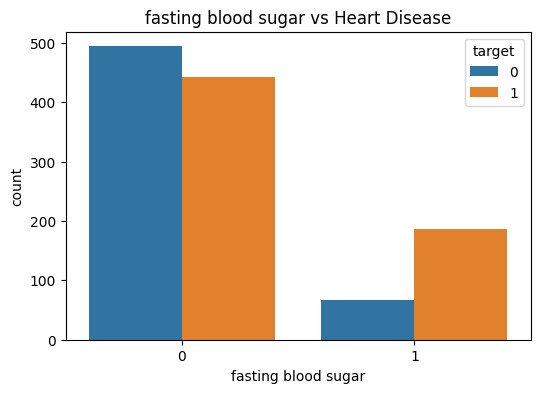

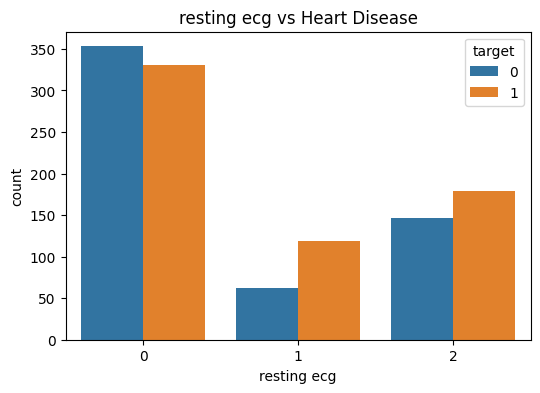

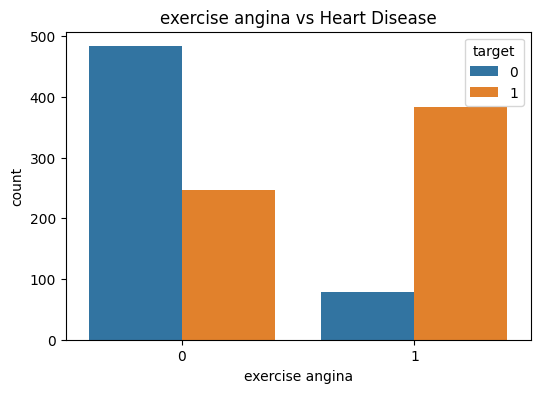

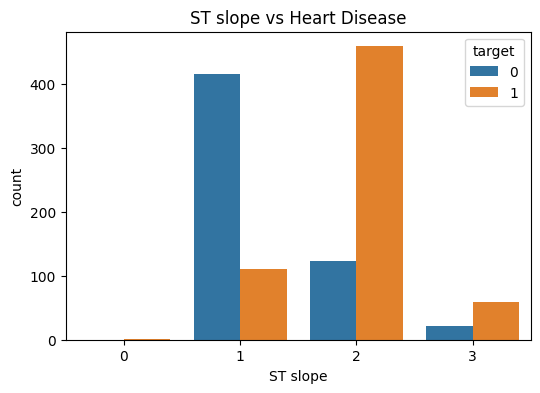

In [8]:
# Categorical features
cat_cols = ['sex', 'chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope']
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, hue='target')
    plt.title(f'{col} vs Heart Disease')
    plt.show()

In [9]:
# Rename columns (fix spacing issues)
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

# Convert categorical columns to strings for one-hot encoding
cat_features = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'resting_ecg', 'exercise_angina', 'st_slope']
df[cat_features] = df[cat_features].astype(str)

# One-hot encode
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True)

# Feature/Target split
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85       112
           1       0.85      0.89      0.87       126

    accuracy                           0.86       238
   macro avg       0.86      0.86      0.86       238
weighted avg       0.86      0.86      0.86       238



In [12]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       112
           1       0.95      0.92      0.94       126

    accuracy                           0.93       238
   macro avg       0.93      0.93      0.93       238
weighted avg       0.93      0.93      0.93       238



In [13]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))

XGBoost:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       112
           1       0.94      0.92      0.93       126

    accuracy                           0.92       238
   macro avg       0.92      0.92      0.92       238
weighted avg       0.92      0.92      0.92       238



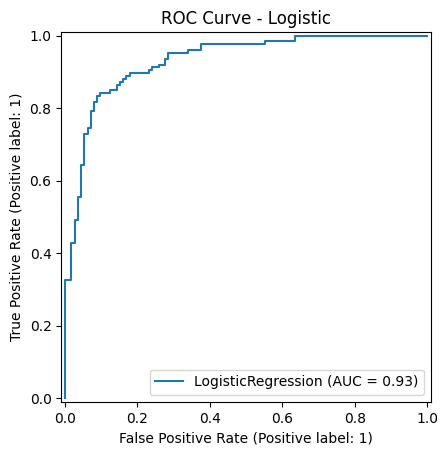

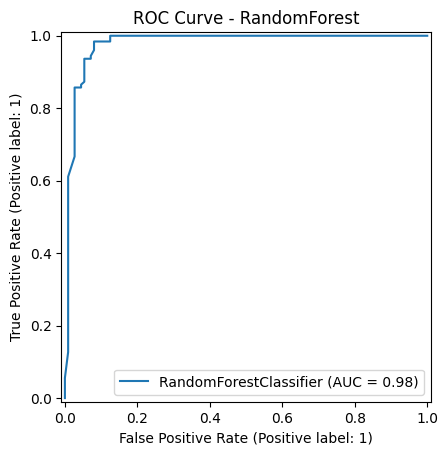

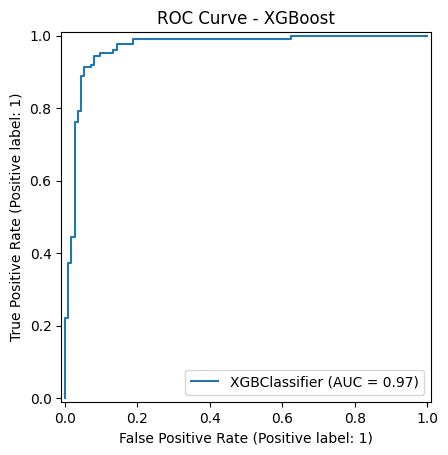

In [14]:
models = {'Logistic': lr, 'RandomForest': rf, 'XGBoost': xgb}
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"ROC Curve - {name}")
    plt.show()

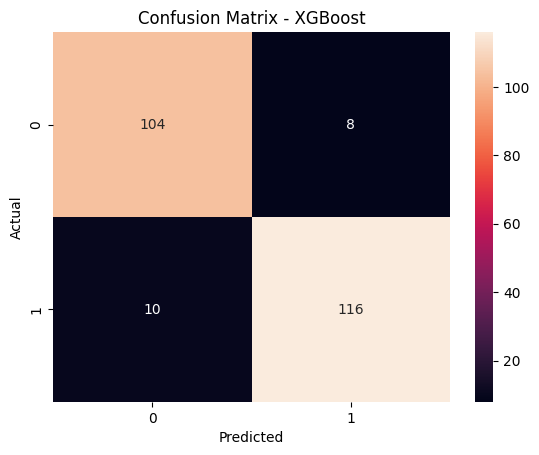

In [15]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

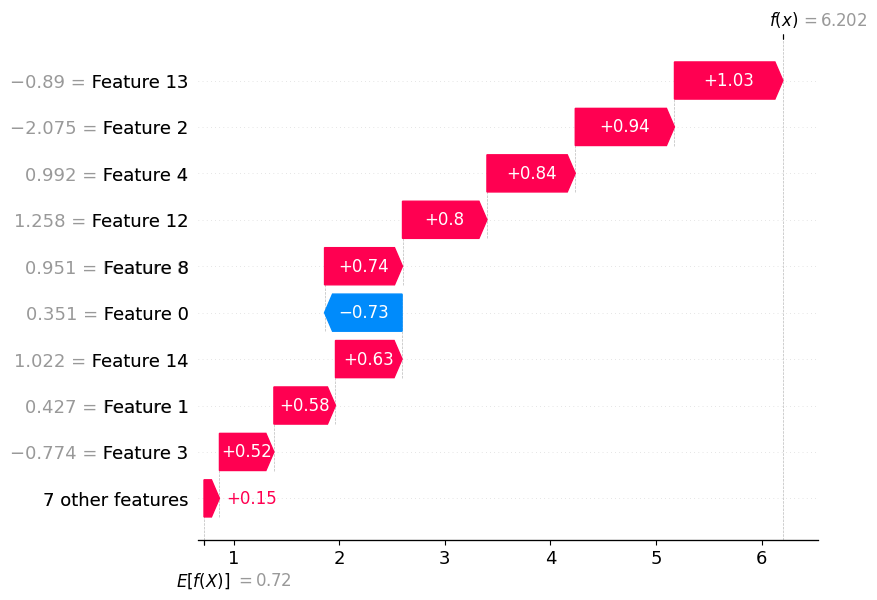

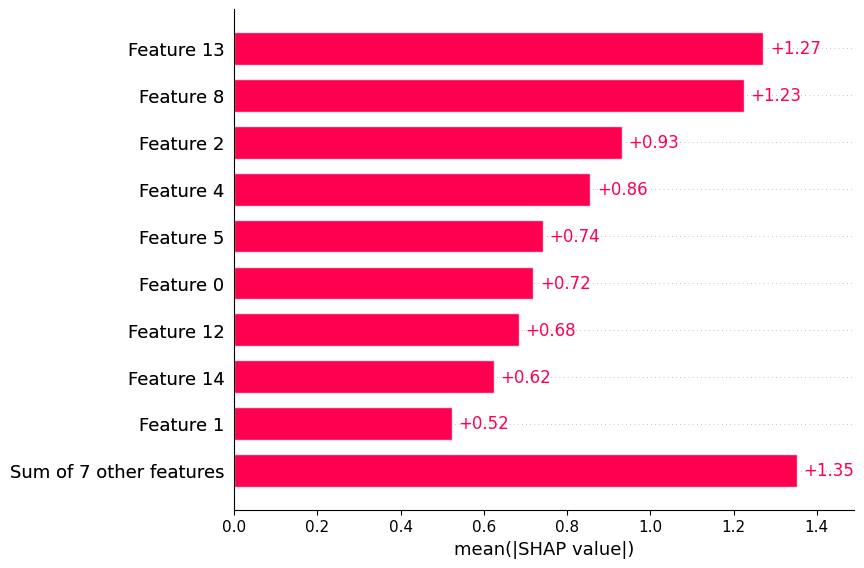

In [16]:
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test[:100])

shap.plots.waterfall(shap_values[0])  # First prediction
shap.plots.bar(shap_values)           # Overall importance

In [17]:
joblib.dump(xgb, 'heart_disease_model_xgb.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']